In [6]:
!pip install -r requirements.txt

In [ ]:
'''
Overall whats happening
```````````````````````
Playing different machines 500 times and looking at the reward each time and storing it in the memory array 
in the format of [index of machine played, reward obtained in the play].

How do we get eache of the above?
`````````````````````````````````
Index of the machine played: This can be selected in two ways

1. Random (Exploration): Look at the else statement of the final code block
2. Based on prior exp (Exploitation): The bestArm function spits out the arm that gave the best reward when fed with the 
    memory array. 

Which of these strategies are taken is decided based on epsilon which is the probability of exploration action

'''

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(5)

In [8]:
n = 10
arms = np.random.rand(n)
eps = 0.1 #probability of exploration action

In [9]:
def reward(prob):
    reward = 0
    for i in range(10):
        if random.random() < prob:
            reward += 1
    return reward

In [128]:
#initialize memory array; has 1 row defaulted to random action index
av = np.array([np.random.randint(0,(n+1)), 0]).reshape(1,2) #av = action-value

In [126]:
#greedy method to select best arm based on memory array
def bestArm(a):
    bestArm = 0 #default to 0
    bestMean = 0
    for u in a:
        avg = np.mean(a[np.where(a[:,0] == u[0])][:, 1]) #calculate mean reward for each action
        if bestMean < avg:
            bestMean = avg
            bestArm = u[0]
    return bestArm

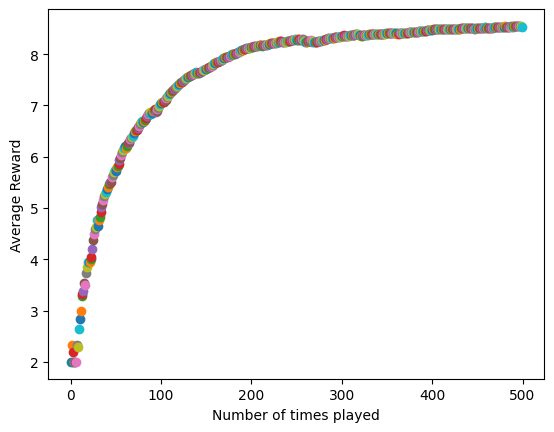

In [130]:
plt.xlabel("Number of times played")
plt.ylabel("Average Reward")
for i in range(500):
    if random.random() > eps: #greedy exploitation action
        choice = bestArm(av)
        thisAV = np.array([[choice, reward(arms[choice])]])
        av = np.concatenate((av, thisAV), axis=0)
    else: #exploration action
        choice = np.where(arms == np.random.choice(arms))[0][0]
        thisAV = np.array([[choice, reward(arms[choice])]]) #choice, reward
        av = np.concatenate((av, thisAV), axis=0) #add to our action-value memory array
    #calculate the mean reward
    runningMean = np.mean(av[:,1])
    plt.scatter(i, runningMean)

In [2]:
import numpy as np
expected_rewards = np.array([1,6,3])
discount_factor = 0.9
discounts = np.array([discount_factor**i for i in range(len(expected_rewards))])
discount_return = np.sum(expected_rewards*discounts)

In [8]:
!pip install gymnasium
!pip install "gymnasium[classic-control]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 10.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [10]:
import gymnasium as gym
env = gym.make('CartPole-v1', render_mode='rgb_array')
state, info = env.reset(seed=42)
print(state)

[ 0.0273956  -0.00611216  0.03585979  0.0197368 ]


In [15]:
import matplotlib.pyplot as plt

def render():

    state_image = env.render()
    plt.imshow(state_image)
    plt.show()

In [29]:
env = gym.make('FrozenLake-v1', is_slippery=False)

In [41]:
env.unwrapped.P[6][0][0]

(1.0, 6, -1, False)

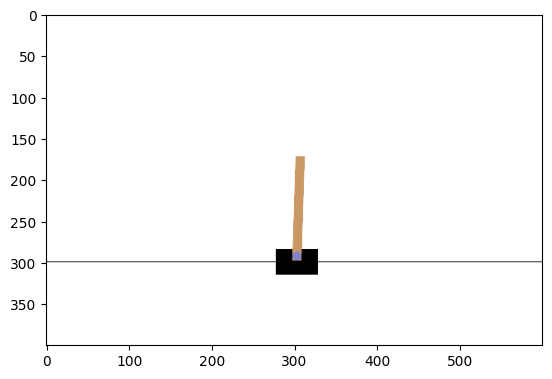

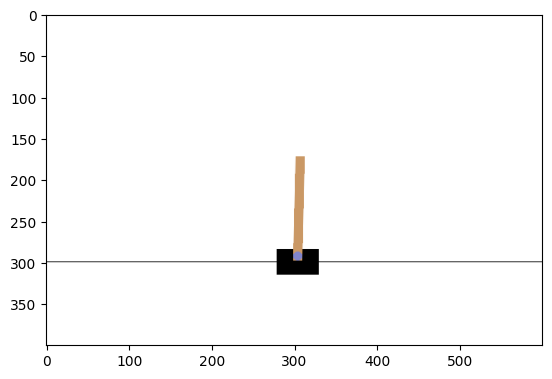

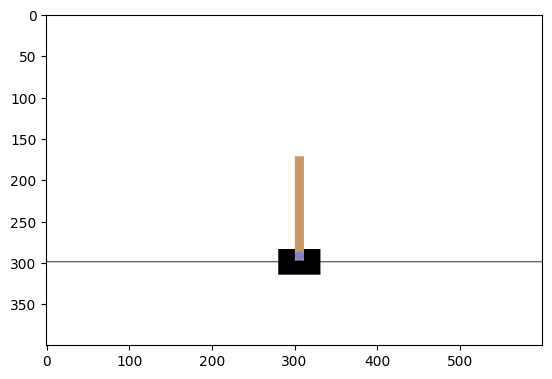

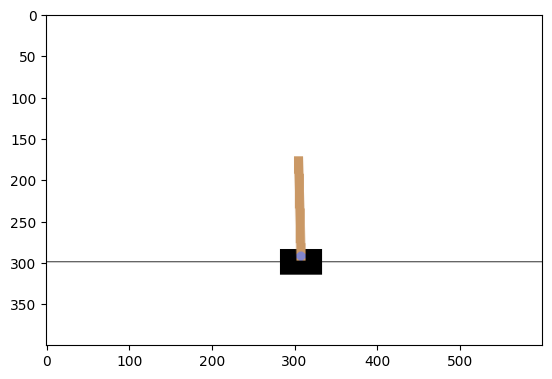

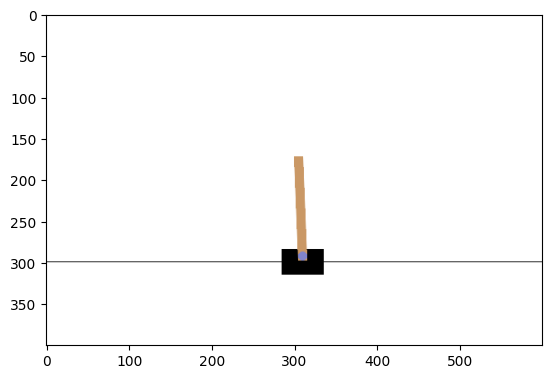

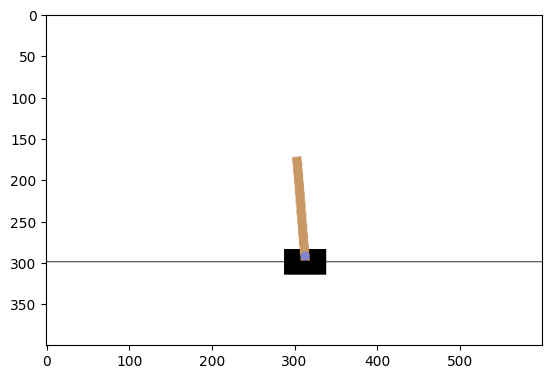

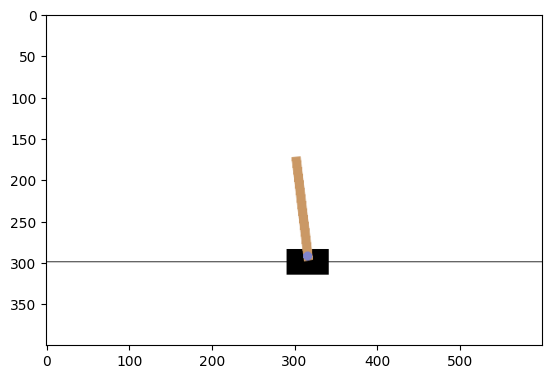

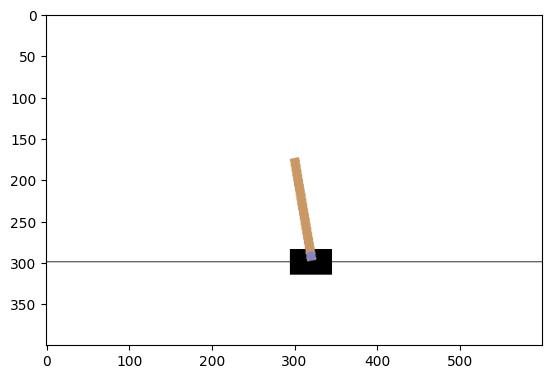

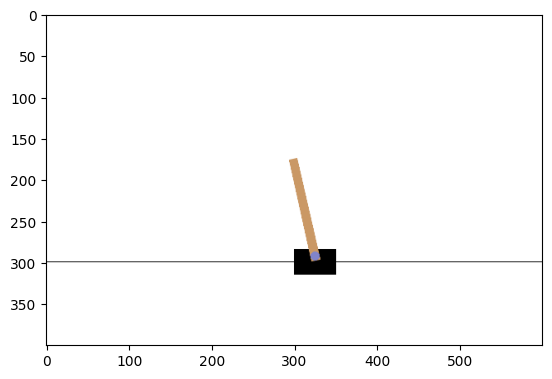

In [23]:
while not terminated:

    action = 1
    state, reward, terminated, truncated, info = env.step(action)
    render()

In [37]:
# Create the Cliff Walking environment
env = gym.make('CliffWalking-v0')

# Compute the size of the action space
num_actions = env.action_space.n

# Compute the size of the state space
num_states = env.observation_space.n

print("Number of actions:", num_actions)
print("Number of states:", num_states)

Number of actions: 4
Number of states: 48


In [29]:
state = 5; action = 0
_, next_state, reward, _ = env.unwrapped.P[state][action][0]

In [30]:
next_state

5

In [26]:
reward

0.0

In [25]:
next_state

5

In [27]:
compute_state_value(5, policy)

RecursionError: maximum recursion depth exceeded

In [23]:
compute_q_value(1, 1, policy)

RecursionError: maximum recursion depth exceeded

In [28]:
policy[5]

0

In [ ]:
state = 5
action = 0

In [ ]:
env.unwrapped.P[1][1][0]

In [22]:
env.unwrapped.P[1][1][0]

(1.0, 5, 0.0, True)

In [1]:
import matplotlib.pyplot as plt
import gymnasium as gym

gamma = 1

# env = gym.make('CartPole-v1', render_mode='rgb_array')
# state, info = env.reset(seed=42)

# Way to get the next state and reward for a give state
# _, next_state, reward, _ = env.unwrapped.P[state][action][0]

terminal_state = False
# Complete the function
def compute_state_value(state, policy):
    if state == terminal_state:
        return 0
    action = policy[state]
    _, next_state, reward, _ = env.unwrapped.P[state][action][0]
    return reward + gamma * compute_state_value(next_state, policy)

# Complete the function to compute the action-value for a state-action pair
def compute_q_value(state, action, policy):
    if state == terminal_state:
        return None   
    _, next_state, reward, _ = env.unwrapped.P[state][action][0]
    return reward + gamma * compute_state_value(next_state, policy)

# Improving policy
# improved_policy = {}

# for state in range(num_states-1):
#     # Find the best action for each state based on Q-values
#     max_action = max(range(num_actions), key=lambda action: Q[(state, action)])
#     improved_policy[state] = max_action

# Rendering a policy
def render():

    state_image = env.render()
    plt.imshow(state_image)
    plt.show()

# terminated = False
# while not terminated:
#   # Select action based on policy 
#   action = improved_policy[state]
#   # Execute the action
#   state, reward, terminated, truncated, info = env.step(action)
#   render()

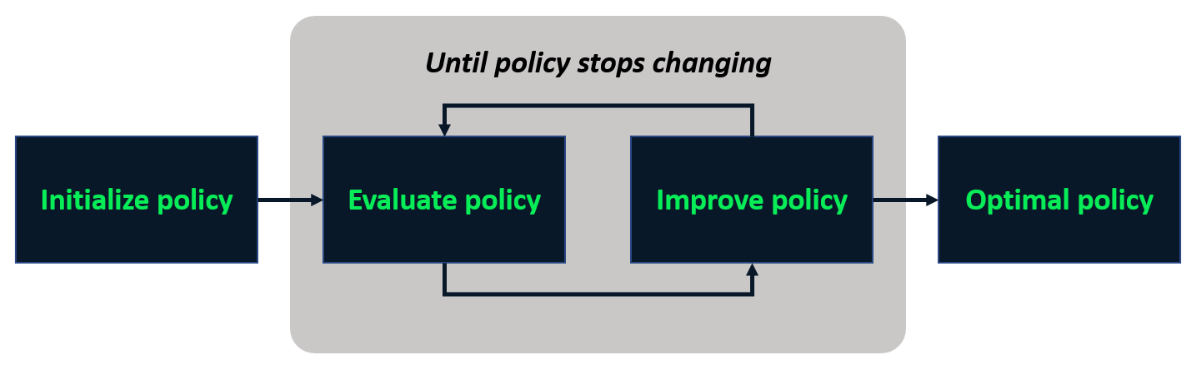

In [2]:
# policy evaluation function
def policy_evaluation(policy):
    '''Creates state value for a given policy'''
    V = {state: compute_state_value(state, policy) for state in range(num_states)}
    return V

# policy improvment
def policy_improvement(policy):

    # Initialize improved policy
    improved_policy = {s:0 for s in range(num_states-1)}

    # Compute Q for each state action pair
    Q = {
        (state, action): compute_q_value(state, action, policy) 
        for state in num_states
        for action in num_actions
    }

    # Find the action with max q for each state and insert that in the initialized improved policy
    for state in range(num_states):

        max_action = max(range(num_actions), key=lambda action: Q[(state, action)])
        improved_policy[state] = max_action

    return improved_policy
